<a href="https://colab.research.google.com/github/cdkontos/MSC-DWS-Machine-Learning-Course-Exercises/blob/main/Exercise_7_SVM_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Question 1

## Load Dataset

In [2]:
df = pd.read_csv("train.csv")
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## Split features and target

In [3]:
df_features  = df.drop(columns=["target"])
df_target = df["target"]

df_features.shape, df_target.shape

((7613, 4), (7613,))

## Split Dataset to Train-Test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size= 0.1, random_state=0, stratify=df_target)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6851, 4), (762, 4), (6851,), (762,))

## Target Bar Plot

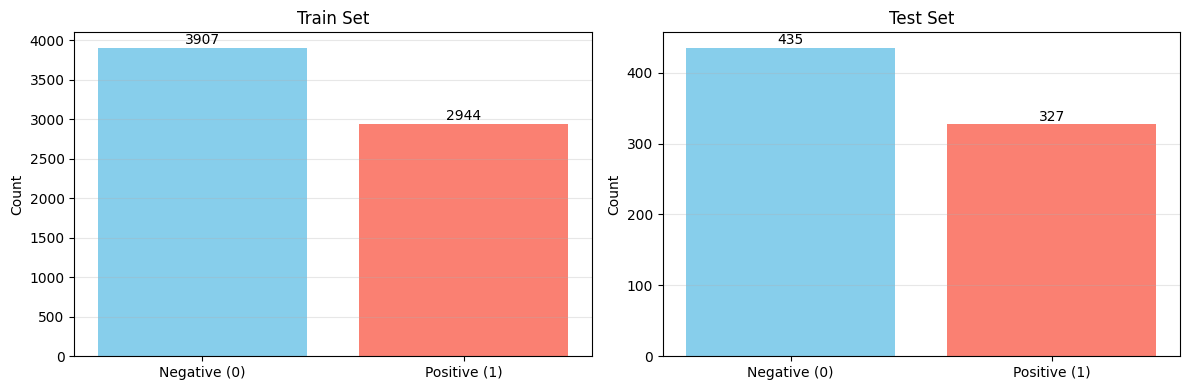

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

axes[0].bar(['Negative (0)', 'Positive (1)'], train_counts.values, color=['skyblue', 'salmon'], label='Train')
axes[0].set_title('Train Set')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center')

axes[1].bar(['Negative (0)', 'Positive (1)'], test_counts.values, color=['skyblue', 'salmon'], label='Test')
axes[1].set_title('Test Set')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

## Dataset Balance

In [6]:
total = len(y_train)

print(f"Percetnage of positive targets: {train_counts[0]} ({train_counts[0]/total*100:.1f}%) ")
print(f"Percentage of negative targets: {train_counts[1]} ({train_counts[1]/total*100:.1f}%)")

Percetnage of positive targets: 3907 (57.0%) 
Percentage of negative targets: 2944 (43.0%)


While the dataset can't be characterized as completely balanced, the percentages are such that, while there is a 14% difference between the classes, the imbalance this causes is at an acceptable level.

# Question 2

## Remove id and location

In [7]:
x_train = x_train.drop(columns=["id", "location"])
x_test = x_test.drop(columns=["id", "location"])

## Fill missing values

In [8]:
x_train['keyword'] = x_train['keyword'].fillna('null')
x_test['keyword'] = x_test['keyword'].fillna('null')

## Fuse keyword and text columns

In [9]:
x_train['inputs'] = x_train['keyword'] + ' ' + x_train['text']
x_test['inputs'] = x_test['keyword'] + ' ' + x_test['text']
x_train = x_train.drop(columns=["keyword", "text"])
x_test = x_test.drop(columns=["keyword", "text"])

# Question 3

The following text preprocessing techniques were used:


1.   removeUnicode(), which removes unicode strings and non-ASCII characters,  like emojis and special unicode that add noise to the disaster classification.
2.   replaceURL(), which replaces URLs with a 'url' token, as URLs don't provvide semantic vlue for disaster detection.
3.   replaceAtUser(), which replaces @mentions with an 'atUser' token, as user mentions are not relevant for identifying disaster content.
4.   removeHashtagInFrontOfWord(), which removes the # symbol but keeps the word, as the hashtag itself is useful but the # symbol is not.
5.   removeNumbers(), which removes all numeric digits, as numbers generally don't help classify disaster and non-disaster tweets.
6.   removeEmoticons(), which removes all test-based emoticons, as they add noise and don't contribute to disaster identification.



In [10]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\)'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\)'
/tmp/ipython-input-482128455.py:9: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/tmp/ipython-input-482128455.py:15: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+','atUser',text)
/tmp/ipython-input-482128455.py:30: SyntaxWarning: invalid escape sequence '\)'
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


In [11]:
def preprocess_text(text):
  text = removeUnicode(text)
  text = replaceURL(text)
  text = replaceAtUser(text)
  text = removeHashtagInFrontOfWord(text)
  text = removeNumbers(text)
  text = removeEmoticons(text)
  return text

## Preprocess Train data

In [12]:
for i in range(len(x_train)):
    text = x_train['inputs'].iloc[i]
    text = preprocess_text(text=text)
    x_train.iloc[i, 0] = text
x_train

,inputs
6669,threat Meek Mill responds to Drakes OVO Fest s...
3940,flood survived the plague\nfloated the flood\n...
7217,weapons Kick Hendrixonfire atUser | BIG NOOB ...
2234,deluge Vince McMahon once again a billionaire ...
4233,hazardous Is it possible to sneak into a hospi...
...,...
3865,flames atUser want to burst into flames! *Anna...
6854,trauma Photo lavenderpoetrycafe The Forgotten ...
5669,rescue Officials rescue migrants off Libya; ...
3397,explode If Ryan doesn't release new music soon...


## Preprocess Test data

In [13]:
for i in range(len(x_test)):
    text = x_test['inputs'].iloc[i]
    text = preprocess_text(text=text)
    x_test.iloc[i, 0] = text
x_test

,inputs
604,bioterror FedEx no longer to transport bioterr...
5374,panic Panic over Patient in Alabama tests nega...
3022,dust%storm New Mad Max Screenshots Show Off a ...
3357,evacuated Rocky fire in Northern California sw...
4726,lava atUser Lava Blast &amp; Power Red atUser ...
...,...
5098,nuclear%disaster refugees of nuclear disaster ...
525,avalanche Musician Kalle Mattson Recreates Cl...
5169,obliterate atUser good sir I did not wish to b...
3592,fatal Man charged over fatal crash near Dubbo ...


# Question 4

In [14]:
inputs_train_array = x_train['inputs'].to_numpy()
targets_train_array = y_train.to_numpy()

inputs_test_array = x_test['inputs'].to_numpy()
targets_test_array = y_test.to_numpy()

inputs_train_array.shape, targets_train_array.shape, inputs_test_array.shape, targets_test_array.shape

((6851,), (6851,), (762,), (762,))

# Question 5

In [15]:
vectorizer = TfidfVectorizer()

inputs_train = vectorizer.fit_transform(inputs_train_array)
inputs_test = vectorizer.transform(inputs_test_array)

inputs_train.shape, inputs_test.shape

((6851, 13504), (762, 13504))

# Question 6

In [20]:
linear_svm = LinearSVC(random_state=0)
linear_svm.fit(inputs_train, targets_train_array)

y_pred_train = linear_svm.predict(inputs_train)
accuracy_train = accuracy_score(targets_train_array, y_pred_train)
f1_train = f1_score(targets_train_array, y_pred_train)
precision_train = precision_score(targets_train_array, y_pred_train)
recall_train = recall_score(targets_train_array, y_pred_train)

y_pred_test = linear_svm.predict(inputs_test)
accuracy_test = accuracy_score(targets_test_array, y_pred_test)
f1_test = f1_score(targets_test_array, y_pred_test)
precision_test = precision_score(targets_test_array, y_pred_test)
recall_test = recall_score(targets_test_array, y_pred_test)

print("Accuracy Train: ", accuracy_train)
print("Precision Train ", precision_train)
print("Recall Train: ", recall_train)
print("F1 Train: ", f1_train)
print()
print("Accuracy Test: ", accuracy_test)
print("Precision Test ", precision_test)
print("Recall Test: ", recall_test)
print("F1 Test: ", f1_test)

linSVC_metrics_train = [accuracy_train, precision_train, recall_train, f1_train]
linSVC_metrics_test = [accuracy_test, precision_test, recall_test, f1_test]

Accuracy Train:  0.9613195153992118
Precision Train  0.9755058572949947
Recall Train:  0.9334239130434783
F1 Train:  0.9540010414858532

Accuracy Test:  0.800524934383202
Precision Test  0.7850162866449512
Recall Test:  0.7370030581039755
F1 Test:  0.7602523659305994


The most important metric is recall, as the model must be able to detect as many disasters as possible, as false negatives, that is missing a real disaster, are much more dangerous than false positives, that is false alarms in case a disaster is not really under way. Therefore, maximizing recall ensures all disasters are caught, even if some false alarms might occur as human lives are more important than avoiding them.

# Question 7

## PCA Transformation

In [17]:
pca = PCA(n_components=0.95, random_state=0)
inputs_train_pca = pca.fit_transform(inputs_train.toarray())
inputs_test_pca = pca.transform(inputs_test.toarray())

inputs_train_pca.shape, inputs_test_pca.shape

((6851, 3731), (762, 3731))

## LinearSVC training

In [21]:
linear_svm = LinearSVC(random_state=0)
linear_svm.fit(inputs_train_pca, targets_train_array)

y_pred_train = linear_svm.predict(inputs_train_pca)
accuracy_train = accuracy_score(targets_train_array, y_pred_train)
f1_train = f1_score(targets_train_array, y_pred_train)
precision_train = precision_score(targets_train_array, y_pred_train)
recall_train = recall_score(targets_train_array, y_pred_train)

y_pred_test = linear_svm.predict(inputs_test_pca)
accuracy_test = accuracy_score(targets_test_array, y_pred_test)
f1_test = f1_score(targets_test_array, y_pred_test)
precision_test = precision_score(targets_test_array, y_pred_test)
recall_test = recall_score(targets_test_array, y_pred_test)

print("Accuracy Train: ", accuracy_train)
print("Precision Train ", precision_train)
print("Recall Train: ", recall_train)
print("F1 Train: ", f1_train)
print()
print("Accuracy Test: ", accuracy_test)
print("Precision Test ", precision_test)
print("Recall Test: ", recall_test)
print("F1 Test: ", f1_test)

linSVC_metrics_train_pca = [accuracy_train, precision_train, recall_train, f1_train]
linSVC_metrics_test_pca = [accuracy_test, precision_test, recall_test, f1_test]

Accuracy Train:  0.9369435118960736
Precision Train  0.9550724637681159
Recall Train:  0.8953804347826086
F1 Train:  0.9242636746143057

Accuracy Test:  0.8097112860892388
Precision Test  0.7954545454545454
Recall Test:  0.7492354740061162
F1 Test:  0.7716535433070866


## SVC training with RBF kernel

In [22]:
svc = SVC(kernel='rbf', random_state=0)
svc.fit(inputs_train_pca, targets_train_array)

y_pred_train = svc.predict(inputs_train_pca)
accuracy_train = accuracy_score(targets_train_array, y_pred_train)
f1_train = f1_score(targets_train_array, y_pred_train)
precision_train = precision_score(targets_train_array, y_pred_train)
recall_train = recall_score(targets_train_array, y_pred_train)

y_pred_test = svc.predict(inputs_test_pca)
accuracy_test = accuracy_score(targets_test_array, y_pred_test)
f1_test = f1_score(targets_test_array, y_pred_test)
precision_test = precision_score(targets_test_array, y_pred_test)
recall_test = recall_score(targets_test_array, y_pred_test)

print("Accuracy Train: ", accuracy_train)
print("Precision Train ", precision_train)
print("Recall Train: ", recall_train)
print("F1 Train: ", f1_train)
print()
print("Accuracy Test: ", accuracy_test)
print("Precision Test ", precision_test)
print("Recall Test: ", recall_test)
print("F1 Test: ", f1_test)

svc_metrics_train_pca = [accuracy_train, precision_train, recall_train, f1_train]
svc_metrics_test_pca = [accuracy_test, precision_test, recall_test, f1_test]

Accuracy Train:  0.9442417165377317
Precision Train  0.9726937269372694
Recall Train:  0.8953804347826086
F1 Train:  0.9324372125928546

Accuracy Test:  0.8136482939632546
Precision Test  0.8013029315960912
Recall Test:  0.7522935779816514
F1 Test:  0.7760252365930599


The SVC with RBF metrics are in general very slightly higher than those of the LinearSVC.

# Question 8

The value of gamma for:


*   scale is **γ = 1 / (n_features * X.var())**
*   auto is  **γ = 1 / n_features**



## SVC training with RBF kernel with gamma = 'auto'

In [23]:
svc = SVC(kernel='rbf', gamma='auto', random_state=0)
svc.fit(inputs_train_pca, targets_train_array)

y_pred_train = svc.predict(inputs_train_pca)
accuracy_train = accuracy_score(targets_train_array, y_pred_train)
f1_train = f1_score(targets_train_array, y_pred_train)
precision_train = precision_score(targets_train_array, y_pred_train)
recall_train = recall_score(targets_train_array, y_pred_train)

y_pred_test = svc.predict(inputs_test_pca)
accuracy_test = accuracy_score(targets_test_array, y_pred_test)
f1_test = f1_score(targets_test_array, y_pred_test)
precision_test = precision_score(targets_test_array, y_pred_test)
recall_test = recall_score(targets_test_array, y_pred_test)

print("Accuracy Train: ", accuracy_train)
print("Precision Train ", precision_train)
print("Recall Train: ", recall_train)
print("F1 Train: ", f1_train)
print()
print("Accuracy Test: ", accuracy_test)
print("Precision Test ", precision_test)
print("Recall Test: ", recall_test)
print("F1 Test: ", f1_test)

svc_metrics_train_pca_auto = [accuracy_train, precision_train, recall_train, f1_train]
svc_metrics_test_pca_auto = [accuracy_test, precision_test, recall_test, f1_test]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy Train:  0.570281710699168
Precision Train  0.0
Recall Train:  0.0
F1 Train:  0.0

Accuracy Test:  0.5708661417322834
Precision Test  0.0
Recall Test:  0.0
F1 Test:  0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Train and Test set metrics Bar Plot

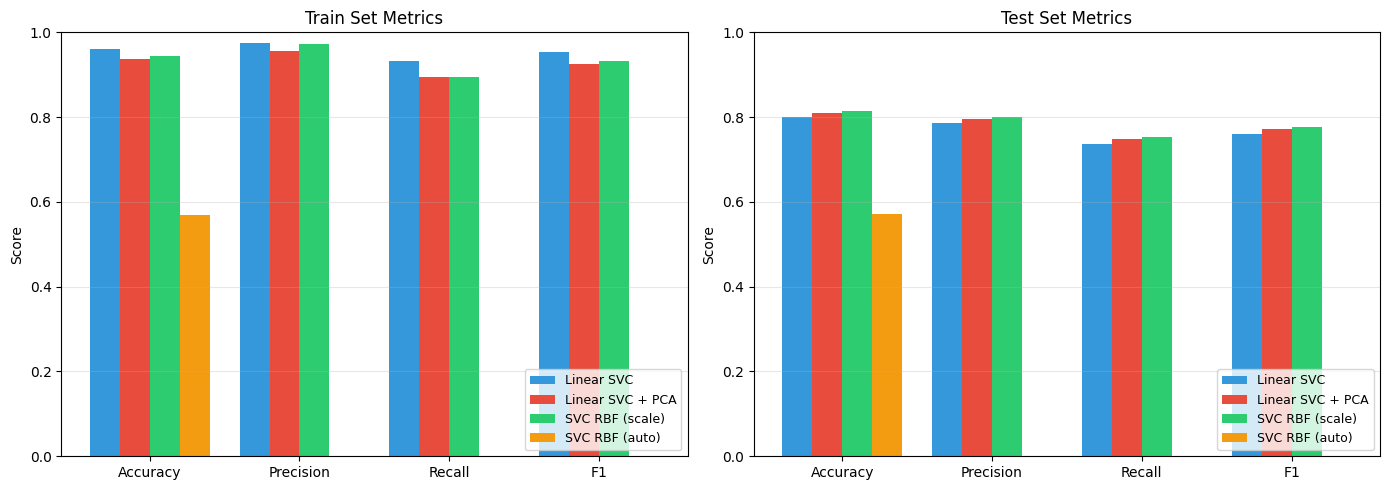

In [42]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(labels))
width = 0.2

models_train = [linSVC_metrics_train, linSVC_metrics_train_pca, svc_metrics_train_pca, svc_metrics_train_pca_auto]
models_test = [linSVC_metrics_test, linSVC_metrics_test_pca, svc_metrics_test_pca, svc_metrics_test_pca_auto]
model_names = ['Linear SVC', 'Linear SVC + PCA', 'SVC RBF (scale)', 'SVC RBF (auto)']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (metrics, name, color) in enumerate(zip(models_train, model_names, colors)):
    offset = (i - 1.5) * width
    axes[0].bar(x + offset, metrics, width, label=name, color=color)

axes[0].set_title('Train Set Metrics')
axes[0].set_ylabel('Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

for i, (metrics, name, color) in enumerate(zip(models_test, model_names, colors)):
    offset = (i - 1.5) * width
    axes[1].bar(x + offset, metrics, width, label=name, color=color)

axes[1].set_title('Test Set Metrics')
axes[1].set_ylabel('Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylim([0, 1])
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Question 9

In [53]:
bayes = GaussianNB()
bayes.fit(inputs_train.toarray(), targets_train_array)

y_pred_train = bayes.predict(inputs_train.toarray())
accuracy_train = accuracy_score(targets_train_array, y_pred_train)
f1_train = f1_score(targets_train_array, y_pred_train)
precision_train = precision_score(targets_train_array, y_pred_train)
recall_train = recall_score(targets_train_array, y_pred_train)

y_pred_test = bayes.predict(inputs_test.toarray())
accuracy_test = accuracy_score(targets_test_array, y_pred_test)
f1_test = f1_score(targets_test_array, y_pred_test)
precision_test = precision_score(targets_test_array, y_pred_test)
recall_test = recall_score(targets_test_array, y_pred_test)

print("Accuracy Train: ", accuracy_train)
print("Precision Train ", precision_train)
print("Recall Train: ", recall_train)
print("F1 Train: ", f1_train)
print()
print("Accuracy Test: ", accuracy_test)
print("Precision Test ", precision_test)
print("Recall Test: ", recall_test)
print("F1 Test: ", f1_test)

Accuracy Train:  0.8794336593198073
Precision Train  0.7809018567639258
Recall Train:  1.0
F1 Train:  0.8769734882335418

Accuracy Test:  0.6181102362204725
Precision Test  0.5368852459016393
Recall Test:  0.8012232415902141
F1 Test:  0.6429447852760736
